In [18]:
using PyPlot

## JuMP model

In [38]:
t = [2020:2100;] # years
N = length(t)   # number of years
CO₂_init = 415    # concentration(ppm) initially

# physical climate parameters
ECS = 3.0         # Equilibrium Climate Sensitivity
ϵ = ECS / log(2)  # Transient Warming Parameter
δT₀_init = 1.1;    # Warming: initial, preindustrial

# baseline emissions scenarios
q = fill(2, N) # emissions scenario
c₀ = CO₂_init .+ cumsum(q); # cumulative CO2 concentrations (ppm)
δT_0 = δT₀_init .+ ϵ.*log.(c₀/CO₂_init) # warming due to baseline emissions scenario

# economic parameters
β = 2.2 # damage parameter (trillion dollars / C^2)
D_0 = β .* δT₀_init.^2; # baseline damages
γ = 0 #1. /30. # discount rate
C_ϕ = 400 # Negative (emissions) trillion $
C_φ = 100 # Reduction (of emissions) trillion $
C_χ = 150 # Adaptation trillion $
C_λ = 150 # Geoengineering trillion $

# c(ϕ::Array, φ::Array) = (c₀ .- cumsum(q .* φ)) .* (1. .- ϕ);
# δT(ϕ::Array, φ::Array) = δT₀_init .+ ϵ.*log.(c(ϕ,φ)./CO₂_init);

f_low(α) = (α / (1 + α))^2 # shape of individual cost functions

# Damage
# D(ϕ::Array, φ::Array, χ::Array, λ::Array) = (1 .- χ) .* β .* δT(ϕ, φ).^2 .* (1 .- λ).^2
#
# # Cost
# C(ϕ::Array, φ::Array, χ::Array, λ::Array) = C_λ.*f_low(λ) .+ C_ϕ.*f_low(ϕ) .+ C_φ.*f_low(φ) .+ C_χ.*f_low(χ)
#
# # Objective
# T(ϕ::Array, φ::Array, χ::Array, λ::Array) = (
#     sum((C(ϕ, φ, χ, λ) .+ D(ϕ, φ, χ, λ)) .* exp.(.-γ.*(t.-t[1]))) .+
#     1000. * (sum(diff(ϕ).^2) .+ sum(diff(φ).^2) .+ sum(diff(χ).^2) .+ sum(diff(λ).^2)) .+
#     1000. .* (ϕ[1].^2 .+ φ[1].^2 .+ χ[1].^2 .+ λ[1].^2)
# )

f_low (generic function with 1 method)

In [43]:
using JuMP, Ipopt

model = Model(with_optimizer(Ipopt.Optimizer))
register(model, :f_low, 1, f_low, autodiff=true)

function my_log(x)
    if x == 0
        return -1000.0
    else
        return log(x)
    end
end

register(model, :my_log, 1, my_log, autodiff=true)

In [44]:
@variables(model, begin
        0 <= ϕ[1:N] <= 1  # reduce
        0 <= φ[1:N] <= 1  # remove
        0 <= χ[1:N] <= 1  # geoengineering
        0 <= λ[1:N] <= 1  # adapt
end)

@variable(model, cumsum_qφ[1:N]);


In [45]:
for i in 1:N-1
    @constraint(model, cumsum_qφ[i+1] - cumsum_qφ[i] == q[i+1] * φ[i+1])
end
@constraint(model, cumsum_qφ[1] == q[1] * φ[1])

@NLobjective(model, Min, 
    
      sum( (C_λ*f_low(λ[i]) +
            C_ϕ*f_low(ϕ[i]) +
            C_φ*f_low(φ[i]) +
            C_χ*f_low(χ[i])) for i=1:N)
    
     + sum(
        (1 - χ[i]) * β *
        (δT₀_init + ϵ * my_log(cumsum_qφ[i] / CO₂_init))^2 *
        (1 - λ[i])^2 *
        exp(-γ * (t[i] - t[1]))  for i=1:N)
    
     + 1000 * sum( (ϕ[i+1] - ϕ[i])^2 + (φ[i+1] - φ[i])^2 
                  + (λ[i+1] - λ[i])^2 + (χ[i+1] - χ[i])^2 for i=1:N-1 )
        
     + 1000 * (ϕ[1]^2 + φ[1]^2 + χ[1]^2 + λ[1]^2)
    )




@time optimize!(model)


objective_value(model)




This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      242
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      968

Total number of variables............................:      405
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      324
                     variables with only upper bounds:        0
Total number of equality constraints.................:       81
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

3748.659784534427

In [46]:
value.(φ)

81-element Array{Float64,1}:
 0.14494927927802861  
 0.1319946921172193   
 0.11417381330489187  
 0.09905125221834532  
 0.08682909277183093  
 0.07706126729844735  
 0.06927605886313484  
 0.06306375052247037  
 0.05808695881474878  
 0.05407448672870294  
 0.05081139717590455  
 0.04812894633225371  
 0.045895553974265244 
 ⋮                    
 0.00611813091606915  
 0.005621411887401752 
 0.00513272534564766  
 0.004654214776740014 
 0.004188810966609891 
 0.0037405101224933916
 0.003314747898235706 
 0.00291890332253719  
 0.002562983822478103 
 0.00226057536783697  
 0.002030202432923794 
 0.0018973334528662009

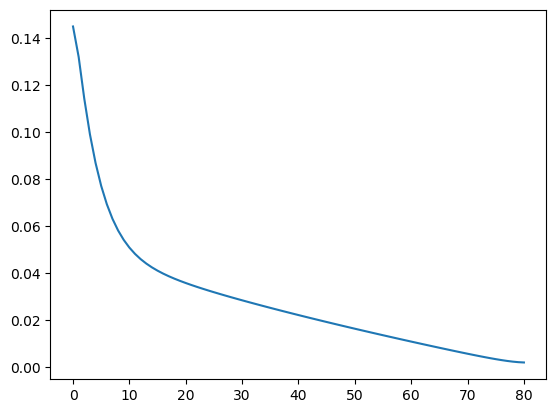

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14d49a550>

In [29]:
plot(value.(φ))

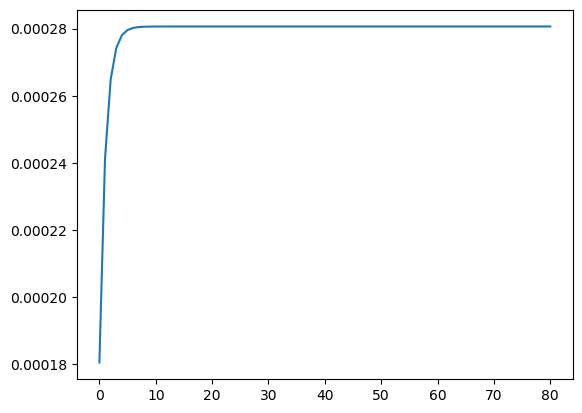

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14d6ff390>

In [30]:
plot(value.(ϕ))

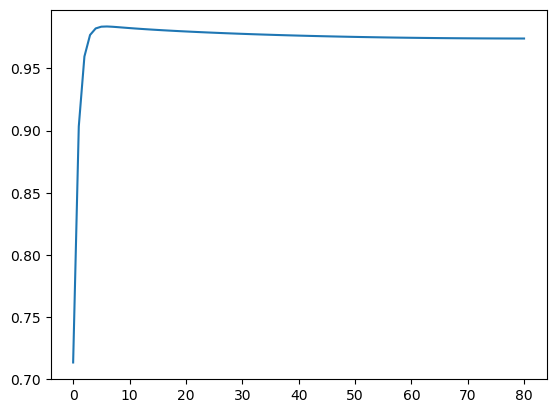

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14d8ad748>

In [31]:
plot(value.(λ))

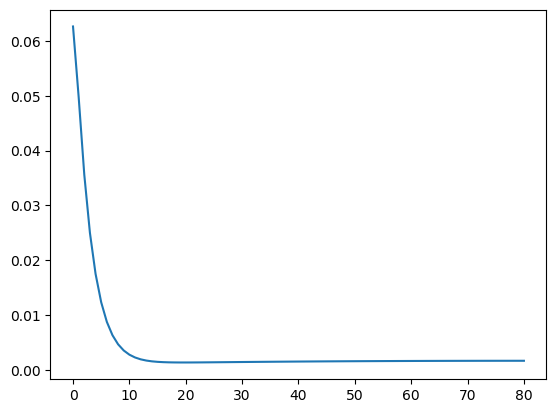

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14d914b00>

In [32]:
plot(value.(χ))